In [ ]:
!pip install sentence_transformers

# Kindly add all your installations and versions if any in this cell.

In [2]:
import pandas as pd
import numpy as np
import spacy
import csv
from scipy import stats
from sklearn import linear_model

from sentence_transformers import SentenceTransformer, losses, models, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.readers import InputExample

import torch 
from torch.utils.data import DataLoader

In [3]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import SnowballStemmer
import re
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [45]:
INPUT_PATH="drive/MyDrive/NLP Ass3 stsbenchmark/"
def read_sts_csv(dataset_type="train", columns=['source', 'type', 'year', 'id', 'score', 'sent_a', 'sent_b']):
  path = INPUT_PATH + "sts-"+ dataset_type + ".csv"
  return pd.read_csv(path,sep="\t",header=None, names=columns,quoting=csv.QUOTE_NONE)

data_train = read_sts_csv("train") # create the train, dev and test dataframes
data_dev = read_sts_csv("dev") # create the train, dev and test dataframes
data_test = read_sts_csv("test") # create the train, dev and test dataframes

final_data=data_train.copy(deep=True)
print(len(data_train))
final_data=final_data.append(data_dev,ignore_index=True)
print(len(data_dev))
final_data=final_data.append(data_test,ignore_index=True)
print(len(data_test))


5749
1500
1379


In [46]:
print(len(final_data))
final_data



8628


,source,type,year,id,score,sent_a,sent_b
0,main-captions,MSRvid,2012test,1,5.00,A plane is taking off.,An air plane is taking off.
1,main-captions,MSRvid,2012test,4,3.80,A man is playing a large flute.,A man is playing a flute.
2,main-captions,MSRvid,2012test,5,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,main-captions,MSRvid,2012test,6,2.60,Three men are playing chess.,Two men are playing chess.
4,main-captions,MSRvid,2012test,9,4.25,A man is playing the cello.,A man seated is playing the cello.
...,...,...,...,...,...,...,...
8623,main-news,headlines,2016,1354,0.00,"Philippines, Canada pledge to further boost re...",Philippines saves 100 after ferry sinks
8624,main-news,headlines,2016,1360,1.00,Israel bars Palestinians from Jerusalem's Old ...,"Two-state solution between Palestinians, Israe..."
8625,main-news,headlines,2016,1368,1.00,How much do you know about Secret Service?,Lawmakers from both sides express outrage at S...
8626,main-news,headlines,2016,1420,0.00,Obama Struggles to Soothe Saudi Fears As Iran ...,Myanmar Struggles to Finalize Voter Lists for ...


In [24]:
data_train.isnull().sum()

source    0
type      0
year      0
id        0
score     0
sent_a    0
sent_b    0
dtype: int64

In [ ]:
data_train.duplicated().sum()

0

In [25]:
def review_to_wordlist(review, remove_stopwords=True):
    # Clean the text, with the option to remove stopwords.
    
    # Convert words to lower case and split them
    words = review.lower().split()

    # Optionally remove stop words (true by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    
    review_text = " ".join(words)

    # Clean the text
    review_text = re.sub(r"[^A-Za-z0-9(),!.?\'\`]", " ", review_text)
    review_text = re.sub(r"\'s", " 's ", review_text)
    review_text = re.sub(r"\'ve", " 've ", review_text)
    review_text = re.sub(r"n\'t", " 't ", review_text)
    review_text = re.sub(r"\'re", " 're ", review_text)
    review_text = re.sub(r"\'d", " 'd ", review_text)
    review_text = re.sub(r"\'ll", " 'll ", review_text)
    review_text = re.sub(r",", " ", review_text)
    review_text = re.sub(r"\.", " ", review_text)
    review_text = re.sub(r"!", " ", review_text)
    review_text = re.sub(r"\(", " ( ", review_text)
    review_text = re.sub(r"\)", " ) ", review_text)
    review_text = re.sub(r"\?", " ", review_text)
    review_text = re.sub(r"\s{2,}", " ", review_text)
    
    words = review_text.split()
    
    # Shorten words to their stems
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in words]
    
    review_text = " ".join(stemmed_words)
    
    # Return a list of words
    # print(review_text)
    return(review_text)

In [47]:
list1=[]
list2=[]
for i in final_data['sent_a']:
  list1.append(review_to_wordlist(i))
final_data['sent_a']=list1
for i in final_data['sent_b']:
  list2.append(review_to_wordlist(i))
final_data['sent_b']=list2

In [27]:
final_data['sent_a'][1]

'man play larg flute'

In [48]:
# Contains the processed questions for Doc2Vec
sent_labeled = []

for i in range(len(final_data['sent_a'])):
    # Question strings need to be separated into words
    # Each question needs a unique label
    sent_labeled.append(LabeledSentence(final_data['sent_a'][i].split(), final_data[final_data.index == i].id))
    sent_labeled.append(LabeledSentence(final_data['sent_b'][i].split(), final_data[final_data.index == i].id))

<ipython-input-48-0c4749e6b197>:7: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  sent_labeled.append(LabeledSentence(final_data['sent_a'][i].split(), final_data[final_data.index == i].id))
<ipython-input-48-0c4749e6b197>:8: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  sent_labeled.append(LabeledSentence(final_data['sent_b'][i].split(), final_data[final_data.index == i].id))


In [49]:
print(sent_labeled[5000])

LabeledSentence(['protest', 'rush', 'stage', 'twice', 'cut', 'power', 'microphon', 'hedg', 'drew', 'speech', 'earli', 'close'], 2500    81
Name: id, dtype: int64)


In [50]:
model = Doc2Vec(dm = 1, min_count=1, window=10, size=150, sample=1e-4, negative=10)
model.build_vocab(sent_labeled)

/usr/local/lib/python3.8/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [51]:
# 20 epochs performs a bit better, but timed out when uploading
# for epoch in range(5):
    # model.train(sent_labeled)
model.train(sent_labeled, total_examples=model.corpus_count, epochs=200)
    # print("Epoch #{} is complete.".format(epoch+1))

In [64]:
# model.most_similar('smoke')

<ipython-input-64-2d707f8dacca>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  model.most_similar('smoke')


[('exempt', 0.8672272562980652),
 ('patron', 0.8593421578407288),
 ('hubbard', 0.8487163782119751),
 ('defec', 0.8383276462554932),
 ('compost', 0.8358578681945801),
 ('litterbox', 0.8344850540161133),
 ('subvers', 0.8289760947227478),
 ('galant', 0.8253263831138611),
 ('neurolog', 0.823425829410553),
 ('wrinkl', 0.8227075934410095)]

In [52]:
print(len(sent_labeled))

17256


In [82]:

sent_a_split = []
for i in range(len(data_train['sent_a'])):
    sent_a_split.append(final_data['sent_a'][i].split())
    
sent_b_split = []
for i in range(len(data_train['sent_b'])):
    sent_b_split.append(final_data['sent_b'][i].split())

In [83]:

sent_a_split_test = []
for i in range(7249, len(final_data['sent_a'])):
    sent_a_split_test.append(final_data['sent_a'][i].split())
    
sent_b_split_test = []
for i in range(7249, len(final_data['sent_b'])):
    sent_b_split_test.append(final_data['sent_b'][i].split())

In [61]:
print(len(final_data['sent_b']))

8628


In [ ]:
doc2vec_scores = []
for i in range(len(sent_a_split)):
    # n_similarity computes the cosine similarity in Doc2Vec
    score = model.n_similarity(sent_a_split[i],sent_b_split[i])
    doc2vec_scores.append(score)
print(doc2vec_scores)

In [ ]:
# words = model.wv.vocab
# print(model.wv['war'])

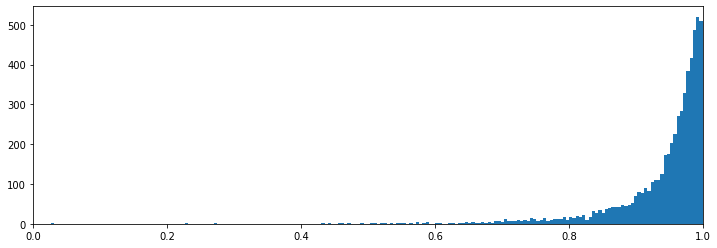

In [65]:
plt.figure(figsize=(12,4))
plt.hist(doc2vec_scores, bins = 200)
plt.xlim(0,1)
plt.show()

In [ ]:
# ind=5635            
# print(str(sent_a_split[ind])+" "+ str(sent_b_split[ind])+" "+ str(doc2vec_scores[ind]))

In [ ]:
# for i in range(len(doc2vec_scores)):
#   if doc2vec_scores[i]<0.6:
#     print(str(i)+" "+str(doc2vec_scores[i]))

In [85]:
len(sent_a_split_test)

1379

In [86]:
sent_vect_all=[]
sent_vect=[]
for j in range(len(sent_a_split)):
  sent_vect=[]
  for i in model.infer_vector(sent_a_split[j], steps=20):
    sent_vect.append(i)
  for i in model.infer_vector(sent_b_split[j], steps=20):
    sent_vect.append(i)
  sent_vect_all.append(np.array(sent_vect))

In [89]:
sent_vect_all_test=[]
sent_vect=[]
for j in range(len(sent_a_split_test)):
  sent_vect=[]
  for i in model.infer_vector(sent_a_split_test[j], steps=20):
    sent_vect.append(i)
  for i in model.infer_vector(sent_b_split_test[j], steps=20):
    sent_vect.append(i)
  sent_vect_all_test.append(np.array(sent_vect))

In [90]:
print(len(sent_vect_all_test))

1379


In [91]:
y_train, x_train = data_train['score'],sent_vect_all


In [97]:
y_test, x_test = data_test['score'],sent_vect_all_test


In [92]:
print((y_train[0]))

5.0


In [93]:
regr = linear_model.LinearRegression()

y=regr.fit(x_train, y_train)
from scipy.stats import spearmanr
print()


In [94]:
ypred=y.predict(x_train)

In [98]:
ypred_test=y.predict(x_test)

In [95]:
print(ypred)
coef, p = spearmanr(ypred, y_train)

[2.3011317 2.582101  2.6548836 ... 2.3955631 1.7887527 2.1720605]


In [100]:
print(ypred_test)
coeft, pt = spearmanr(ypred_test, y_test)

[2.3669887 2.9471078 2.522016  ... 2.1276805 2.5244892 2.618916 ]


In [96]:
print(coef)

0.3053522208534316


In [101]:
print(coeft)

0.1463310661660234


In [ ]:
jkasdbjksdhjasd

In [ ]:

data_train=data_test

list1=[]
list2=[]
for i in data_train['sent_a']:
  list1.append(review_to_wordlist(i))
data_train['sent_a']=list1
for i in data_train['sent_b']:
  list2.append(review_to_wordlist(i))
data_train['sent_b']=list2



# Contains the processed questions for Doc2Vec
sent_labeled = []

for i in range(len(data_train['sent_a'])):
    # Question strings need to be separated into words
    # Each question needs a unique label
    sent_labeled.append(LabeledSentence(data_train['sent_a'][i].split(), data_train[data_train.index == i].id))
    sent_labeled.append(LabeledSentence(data_train['sent_b'][i].split(), data_train[data_train.index == i].id))


sent_a_split = []
for sentence in data_train['sent_a']:
    sent_a_split.append(sentence.split())
    
sent_b_split = []
for sentence in data_train['sent_b']:
    sent_b_split.append(sentence.split())


model.build_vocab(sent_labeled)
model.train(sent_labeled, total_examples=model.corpus_count, epochs=50)



sent_vect_all=[]
sent_vect=[]
for j in range(len(sent_a_split)):
  sent_vect=[]
  for i in model.infer_vector(sent_a_split[j], steps=20):
    sent_vect.append(i)
  for i in model.infer_vector(sent_b_split[j], steps=20):
    sent_vect.append(i)
  sent_vect_all.append(np.array(sent_vect))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).


In [ ]:
y_train, x_train = data_train['score'],sent_vect_all

In [ ]:
for i in sent_a_split:
  print(i)

In [ ]:
ypred=y.predict(x_train)

In [ ]:
print(ypred)
coef, p = spearmanr(ypred, y_train)

[2.5551026 2.477893  2.2829757 ... 2.7419739 2.3035533 2.5714786]


In [ ]:
print(coef)

0.11573511188241879


In [ ]:
dfggddfhdfhdfh

NameError: ignored

In [ ]:
!pip install transformers

In [ ]:
import torch
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
%matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
tokens_tensor_all=[]
segments_tensors_all=[]
both_sent_data=[]
#concatinating both senta and sentb columns, total elements = 5749*2
for i in data_train['sent_a']: 
  both_sent_data.append(i)
for i in data_train['sent_a']: 
  both_sent_data.append(i)



for i in both_sent_data: 
  text = i
  marked_text = "[CLS] " + text + " [SEP]"

  # Tokenize our sentence with the BERT tokenizer.
  tokenized_text = tokenizer.tokenize(marked_text)
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  tokens_tensor = torch.tensor([indexed_tokens])

  segments_ids = [1] * len(tokens_tensor[0])
  segments_tensors = torch.tensor([segments_ids])

  print(tokens_tensor)
  print(segments_tensors)
  tokens_tensor_all.append(tokens_tensor)
  segments_tensors_all.append(segments_tensors)
  # Print out the tokens.
  # print (tokenized_text)

In [ ]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

In [ ]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers.
hidden_states_all=[]
for i in range(len(tokens_tensor_all)):
  with torch.no_grad():

      outputs = model(tokens_tensor_all[i], segments_tensors_all[i])

      # Evaluating the model will return a different number of objects based on 
      # how it's  configured in the `from_pretrained` call earlier. In this case, 
      # becase we set `output_hidden_states = True`, the third item will be the 
      # hidden states from all layers. See the documentation for more details:
      # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
      hidden_states = outputs[2]
      hidden_states_all.append(hidden_states)

In [ ]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings_all=[]
for i in hidden_states_all:

  token_embeddings = torch.stack(i, dim=0)
  token_embeddings_all.append(token_embeddings)

  # token_embeddings.size()

In [ ]:
token_embeddings.size()

In [ ]:
# Remove dimension 1, the "batches".
temp=[]
for i in token_embeddings_all:
  token_embeddings = torch.squeeze(token_embeddings, dim=1)
  temp.append(token_embeddings)
token_embeddings_all=temp
# token_embeddings.size()

In [ ]:
# Swap dimensions 0 and 1.
temp=[]
for i in token_embeddings_all:
  token_embeddings = token_embeddings.permute(1,0,2)
  temp.append(token_embeddings)
token_embeddings_all=temp
# token_embeddings.size()

In [ ]:
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat_all=[]

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for i in token_embeddings_all:
  token_vecs_cat = []
  for token in i:
      
      # `token` is a [12 x 768] tensor

      # Concatenate the vectors (that is, append them together) from the last 
      # four layers.
      # Each layer vector is 768 values, so `cat_vec` is length 3,072.
      cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
      
      # Use `cat_vec` to represent `token`.
      token_vecs_cat.append(cat_vec)
  token_vecs_cat_all.append(token_vecs_cat)

  print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

In [ ]:
# Stores the token vectors, with shape [22 x 768]
token_vecs_cat_all = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for i in token_embeddings_all:
  token_vecs_cat = []
  for token in i:

      # `token` is a [12 x 768] tensor

      # Sum the vectors from the last four layers.
      cat_vec = torch.sum(token[-4:], dim=0)
      
      # Use `sum_vec` to represent `token`.
      token_vecs_cat.append(cat_vec)
  token_vecs_cat_all.append(token_vecs_cat)

  print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

In [ ]:
# `hidden_states` has shape [13 x 1 x 22 x 768]

# `token_vecs` is a tensor with shape [22 x 768]
for i in hidden_states_all:
  token_vecs = i[-2][0]

  # Calculate the average of all 22 token vectors.
  sentence_embedding = torch.mean(token_vecs, dim=0)

In [ ]:
print ("Our final sentence embedding vector of shape:", sentence_embedding.size())

In [ ]:
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)

In [ ]:
print('First 5 vector values for each instance of any word.')
print('')
print(token_vecs_cat)


In [ ]:
print(len(token_vecs_cat_all),len(data_train['sent_a']))

In [ ]:
for i in range(len(token_embeddings_all)):
  temp_vec=[]
  for token in token_embeddings_all[i]:
    for j in token.tolist():
      temp_vec.append(j)
  token_embeddings_all[i]=temp_vec

In [ ]:
sent_a_token_vecs_all=[]
sent_b_token_vecs_all=[]
for i in range(5749):
  sent_a_token_vecs_all.append(token_vecs_cat_all[i])
for i in range(5749,5749*2):
  sent_b_token_vecs_all.append(token_vecs_cat_all[i])
print(len(sent_a_token_vecs_all),len(sent_b_token_vecs_all))



In [ ]:
sent_vects_concat_all=[]
for i in range(5749):
  for j in sent_a_token_vecs_all[i]:
    sent_vects_concat_all.append(j)
  for k in sent_b_token_vecs_all[i]:
    sent_vects_concat_all.append(k)

In [ ]:
y_train, x_train = data_train['score'],sent_vects_concat_all



In [ ]:
regr = linear_model.LinearRegression()

y=regr.fit(x_train, y_train)
from scipy.stats import spearmanr
print()

In [ ]:
ypred=y.predict(x_train)

In [ ]:
print(ypred)
coef, p = spearmanr(ypred, y_train)

In [ ]:
print(coef)